In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
import sys
import torch
from torch_geometric.data import Data
from torch_geometric.data import Dataset, DataLoader
from random import sample 
import os
import networkx as nx
import scipy.io
from scipy.interpolate import griddata


sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk')
print(sys.path)
from pyCaMOtk.create_mesh_hsphere import mesh_hsphere
from pyCaMOtk.create_mesh_hcube import mesh_hcube 
from pyCaMOtk.setup_linelptc_sclr_base_handcode import setup_linelptc_sclr_base_handcode
from pyCaMOtk.create_dbc_strct import create_dbc_strct
from pyCaMOtk.create_femsp_cg import create_femsp_cg
from pyCaMOtk.solve_fem import solve_fem
from pyCaMOtk.visualize_fem import visualize_fem
from pyCaMOtk.lfcnsp import LocalFunctionSpace

sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source')
from FEM_ForwardModel import analyticalParabolic
from GCNNModel import e2vcg2connectivity,PossionNet
from TensorFEMCore_cg import Double,solve_fem_GCNN,create_fem_resjac
import setup_prob_eqn_handcode

torch.manual_seed(0)


c:\Users\puppyCookie\anaconda3\envs\d2l\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\python38.zip', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\DLLs', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l', '', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\Pythonwin']


In [ ]:
"""
Hyper prameters
"""
tol=1.0e-16
maxit=1000
# GCNN model
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model=PossionNet().to(device)
model=model.double()
#加载模型
#model.load_state_dict(torch.load('C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/2dparabolic_2000.pth'))

cuda


In [3]:
"""
Set up GCNN-FEM Possion problem
"""
# 算Δu
# 
nin=1 # Number of input variable
nvar=1 # Number of primanry variable
etype='hcube' # Mesh type
c=[0,0] # Domain center
r=1 # Radius
porder=1 # Polywwwnomial order for solution and geometry basis
nel=[6,3,10] # Number of element in x and y axis

lims = np.array([[0,2],[0,1],[0,0.5]]) # Domain limits
msh=mesh_hcube(etype,lims,nel,porder).getmsh() # Create mesh object


xcg=msh.xcg # Extract node coordinates
print('xcgshape:',xcg.shape)

#xcg[0]是x坐标，xcg[1]是y坐标
ndof=xcg.shape[1] #总节点数，也就是总自由度数
e2vcg=msh.e2vcg # Extract element connectivity 
connectivity=e2vcg2connectivity(msh.e2vcg,'intra') # Extract element connectivity
#输出一下e2vcg


ndim= 3
[[[ nan   0.   1. ... 176. 177. 178.]
  [ nan   3.   3. ...   3.   3.   3.]]

 [[ nan  nan  nan ... 171. 172. 173.]
  [ nan  nan  nan ...   4.   4.   4.]]

 [[ nan  nan  nan ... 159. 160. 161.]
  [ nan  nan  nan ...   5.   5.   5.]]

 [[  1.   2.   3. ... 178. 179.  nan]
  [  0.   0.   0. ...   0.   0.  nan]]

 [[  6.   7.   8. ...  nan  nan  nan]
  [  1.   1.   1. ...  nan  nan  nan]]

 [[ 18.  19.  20. ...  nan  nan  nan]
  [  2.   2.   2. ...  nan  nan  nan]]]
xcgshape: (3, 308)
NnG: 308
NnE: 180
Nrow: 8


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\GCNNModel.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.from_numpy(np.asarray(connectivity).T).to('cuda'), dtype=torch.long)


In [4]:
bnd2nbc=np.asarray([0]) # Define the boundary tag!
K=lambda x,el: np.asarray([[1],[0],[0],[1]]) #这里肯定要改
Qb=lambda x,n,bnd,el,fc: 0
"""
# The flux constant Flux=[du/dx, du/dy]^T=K dot [dphi/dx,dphi/dy]
where phi is the solution polynomial function
""" 

t0_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[2, i],0)]  
x0_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[0, i],0)]
x2_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[0, i],2)]

y0_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[1, i],0)]
y1_boundary_nodes = [i for i in range(xcg.shape[1]) if np.isclose(xcg[1, i],1)]

# 合并所有边界节点索引
dbc_idx = t0_boundary_nodes + x0_boundary_nodes + x2_boundary_nodes + y0_boundary_nodes + y1_boundary_nodes

dbc_idx = np.asarray(dbc_idx)

# 初始化边界值数组
dbc_val = np.zeros_like(dbc_idx, dtype=np.float64)

# 设置边界条件
for idx in range(len(dbc_idx)):
    if dbc_idx[idx] in t0_boundary_nodes:
        #u = e^(x+y)
        dbc_val[idx] = np.exp(xcg[0, dbc_idx[idx]] + xcg[1, dbc_idx[idx]])
    elif dbc_idx[idx] in x0_boundary_nodes:
        #u = e^(y+z)
        dbc_val[idx] = np.exp(xcg[1, dbc_idx[idx]] + xcg[2, dbc_idx[idx]])
    elif dbc_idx[idx] in x2_boundary_nodes:
        #u = e^(2+y+z)
        dbc_val[idx] = np.exp(2 + xcg[1, dbc_idx[idx]] + xcg[2, dbc_idx[idx]])
    elif dbc_idx[idx] in y0_boundary_nodes:
        #u = e^(x+z)
        dbc_val[idx] = np.exp(xcg[0, dbc_idx[idx]] + xcg[2, dbc_idx[idx]])
    elif dbc_idx[idx] in y1_boundary_nodes:
        #u = e^(x+1+z)
        dbc_val[idx] = np.exp(xcg[0, dbc_idx[idx]] + 1 + xcg[2, dbc_idx[idx]])

print('dbc_val:',dbc_val)
# 创建边界条件结构
dbc = create_dbc_strct(xcg.shape[1] * nvar, dbc_idx, dbc_val)

# 其他参数设置
Src_new = torch.tensor([0.25], dtype=torch.double).to('cuda')
K_new = torch.tensor([[1], [0], [0],[0], [1], [0],[0 ], [0], [0]]).to('cuda').double().reshape((9,))#这里肯定不对
parsfuncI = lambda x: torch.cat((K_new, Src_new), axis=0)

dbc_val: [ 1.          1.39561243  1.94773404  2.71828183  3.79366789  5.29449005
  7.3890561   1.39561243  1.94773404  2.71828183  3.79366789  5.29449005
  7.3890561  10.3122585   1.94773404  2.71828183  3.79366789  5.29449005
  7.3890561  10.3122585  14.3919161   2.71828183  3.79366789  5.29449005
  7.3890561  10.3122585  14.3919161  20.08553692  1.          1.39561243
  1.94773404  2.71828183  1.0512711   1.467167    2.0475965   2.85765112
  1.10517092  1.54239027  2.15257902  3.00416602  1.16183424  1.62147031
  2.2629441   3.15819291  1.22140276  1.70460487  2.37896773  3.32011692
  1.28402542  1.79200183  2.50094001  3.49034296  1.34985881  1.88387972
  2.62916595  3.66929667  1.41906755  1.9804683   2.76396617  3.85742553
  1.4918247   2.08200908  2.90567775  4.05519997  1.56831219  2.18875597
  3.05465503  4.26311452  1.64872127  2.30097589  3.21127054  4.48168907
  7.3890561  10.3122585  14.3919161  20.08553692  7.76790111 10.8409793
 15.12980541 21.11534442  8.16616991 11.396

In [5]:
'''
# Define pameterized problem, in this case, the governing equation is changing and the loss
# function is changing
'''
S=[5] # Parametrize the source value in the pde -F_ij,j=S_i
LossF=[]
for i in S: 
	f=lambda x,el: i
	prob=setup_prob_eqn_handcode.setup_linelptc_sclr_base_handcode(2,K,f,Qb,bnd2nbc) # Set up the problem
	femsp=create_femsp_cg(prob,msh,porder,e2vcg,porder,e2vcg,dbc)
	fcn=lambda u_:create_fem_resjac('cg',u_,msh.transfdatacontiguous,
									femsp.elem,femsp.elem_data, 
                   				    femsp.ldof2gdof_eqn.ldof2gdof,
                  			        femsp.ldof2gdof_var.ldof2gdof,
									msh.e2e,femsp.spmat,dbc,[i for i in range(ndof) if i not in dbc_idx],parsfuncI,None)
	LossF.append(fcn)

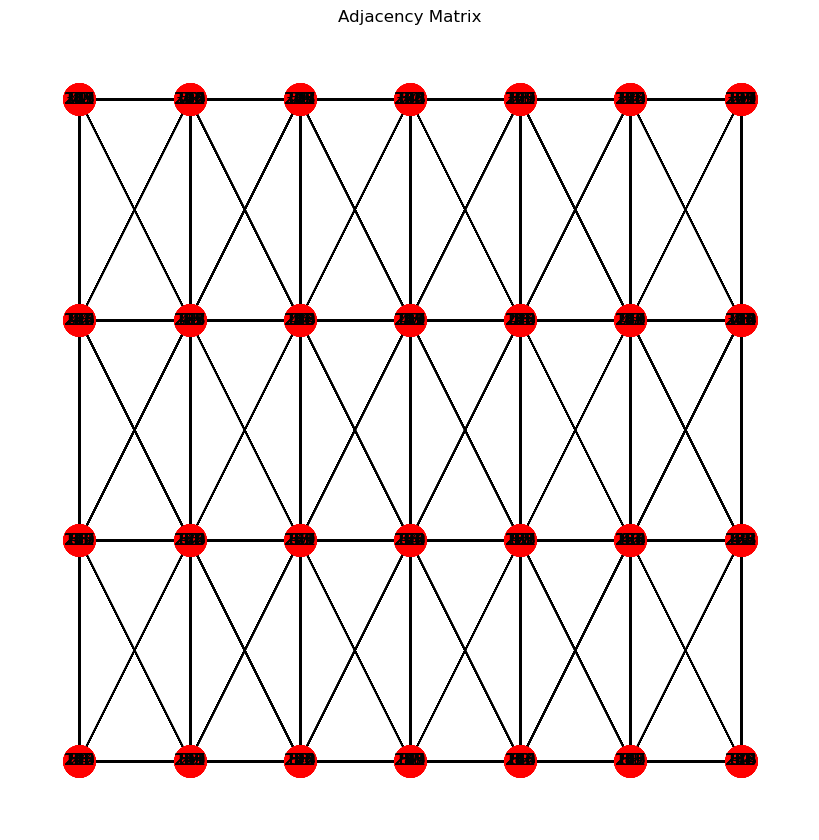

In [6]:
#绘制节点和邻接矩阵的示意图（connectivity是邻接矩阵）
edges = connectivity.cpu().numpy().T.tolist()
G = nx.Graph()
G.add_edges_from(edges)

if xcg.shape[0] == 1:
    # 一维网格：所有节点的y坐标设为0
    pos = {i: (xcg[0, i], 0) for i in range(xcg.shape[1])}
else:
    # 二维网格：直接使用x和y坐标
    pos = {i: (xcg[0, i], xcg[1, i]) for i in range(xcg.shape[1])}
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='r', node_size=500, font_size=12)
plt.title('Adjacency Matrix')
plt.show()

In [ ]:
# Define the Training Data
Ufem=analyticalParabolic(xcg)
Graph=[]
ii=0
for i in S:
	Ue=Double(Ufem.reshape(ndof,1))
	fcn_id=Double(np.asarray([ii]))
	Ue_aug=torch.cat((fcn_id,Ue),axis=0)
	Uin=Double(xcg.T)
	graph=Data(x=Uin,y=Ue_aug,edge_index=connectivity)
	Graph.append(graph)
	ii=ii+1
DataList=[[Graph[i]] for i in range(len(S))]
TrainDataloader=DataLoader(DataList,batch_size=1)
# GCNN model
#device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model=PossionNet().to(device)
#model=model.double()
#存储模型
torch.save(model.state_dict(), 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_PARABOLIC_6310.pth')
# Training Data
[model,info]=solve_fem_GCNN(TrainDataloader,LossF,model,tol,maxit)
print('K=',K)
print('Min Error=',info['Er'].min())
print('Mean Error Last 10 iterations=',np.mean(info['Er'][-10:]))
print('Var  Error Last 10 iterations=',np.var(info['Er'][-10:]))

epoch =  0
Max Rf =============================== tensor(0.8709, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
wallclock time of evl Res=  7.118202209472656
max Res= 0.8708969424956732
wallclock time of this BP=  2.616860866546631
>>>>>>>max error<<<<<<< ==================================== 0.43869112481901623
>>>>>>>model source<<<<<<< ======================= Parameter containing:
tensor([0.2500], device='cuda:0', dtype=torch.float64, requires_grad=True)
Solution er =  0.43869112481901623
wallclock time of this epoch=  9.86952519416809
The training reaches the expected loss!
epoch =  1
Max Rf =============================== tensor(0.7665, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
wallclock time of evl Res=  6.950985670089722
max Res= 0.766507267853217
wallclock time of this BP=  2.495654344558716
>>>>>>>max error<<<<<<< ==================================== 0.27506844317993495
>>>>>>>model source<<<<<<< ======================= Parameter containing:
t

KeyboardInterrupt: 

: 

In [13]:
# Define the Training Data
Ufem=analyticalParabolic(xcg)
Graph=[]
ii=0
for i in S:
	Ue=Double(Ufem.reshape(ndof,1))
	fcn_id=Double(np.asarray([ii]))
	Ue_aug=torch.cat((fcn_id,Ue),axis=0)
	Uin=Double(xcg.T)
	graph=Data(x=Uin,y=Ue_aug,edge_index=connectivity)
	Graph.append(graph)
	ii=ii+1
DataList=[[Graph[i]] for i in range(len(S))]
TrainDataloader=DataLoader(DataList,batch_size=1)

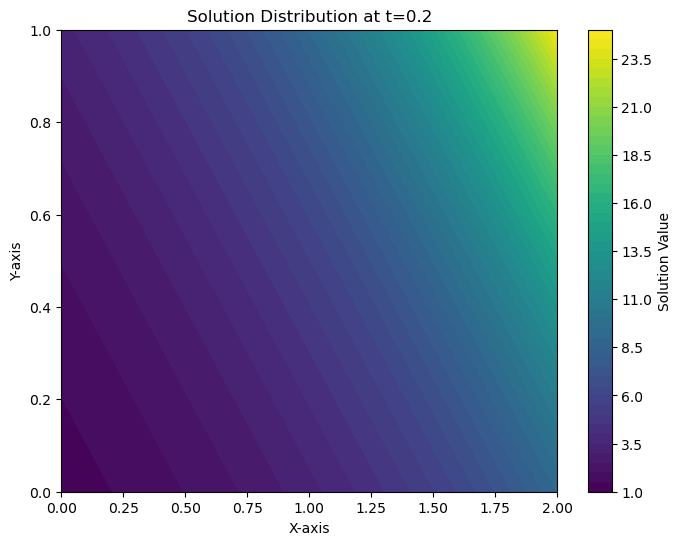

In [23]:
# 画一下真解
# t = 0.2
t = 0.2
# 画出解的分布
plt.figure(figsize=(8, 6))
x = np.linspace(0, 2, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.exp(X + Y + t)  # 计算解的值
# 横坐标X，纵坐标Y，颜色值Z
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Solution Value')
plt.title(f'Solution Distribution at t={t}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


torch.Size([165, 1])
solution_values: [[ 1.        ]
 [ 1.64872127]
 [ 2.71828183]
 [ 4.48168907]
 [ 7.3890561 ]
 [ 1.64872127]
 [ 2.71828183]
 [ 4.48168907]
 [ 7.3890561 ]
 [12.18249396]
 [ 2.71828183]
 [ 4.48168907]
 [ 7.3890561 ]
 [12.18249396]
 [20.08553692]]
ndim= 2
[[[nan  0.  1.  2. nan  4.  5.  6.]
  [nan  2.  2.  2. nan  2.  2.  2.]]

 [[nan nan nan nan  0.  1.  2.  3.]
  [nan nan nan nan  3.  3.  3.  3.]]

 [[ 1.  2.  3. nan  5.  6.  7. nan]
  [ 0.  0.  0. nan  0.  0.  0. nan]]

 [[ 4.  5.  6.  7. nan nan nan nan]
  [ 1.  1.  1.  1. nan nan nan nan]]]
ndof: 15
15
[[ 0  1  2  3  5  6  7  8]
 [ 1  2  3  4  6  7  8  9]
 [ 5  6  7  8 10 11 12 13]
 [ 6  7  8  9 11 12 13 14]]
zeval: [[-1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5
   1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5 -0.5 -0.5 -0.5 -0.5  0.   0.   0.   0.
   0.   0.5  0.5  0.5  0.5  0.5  1.   1.   1.   1.   1. ]]
评估点的数量  25
zeval: [[-1.  -0.5  0.   0.5  1. 

AttributeError: 'numpy.ndarray' object has no attribute 'tick_params'

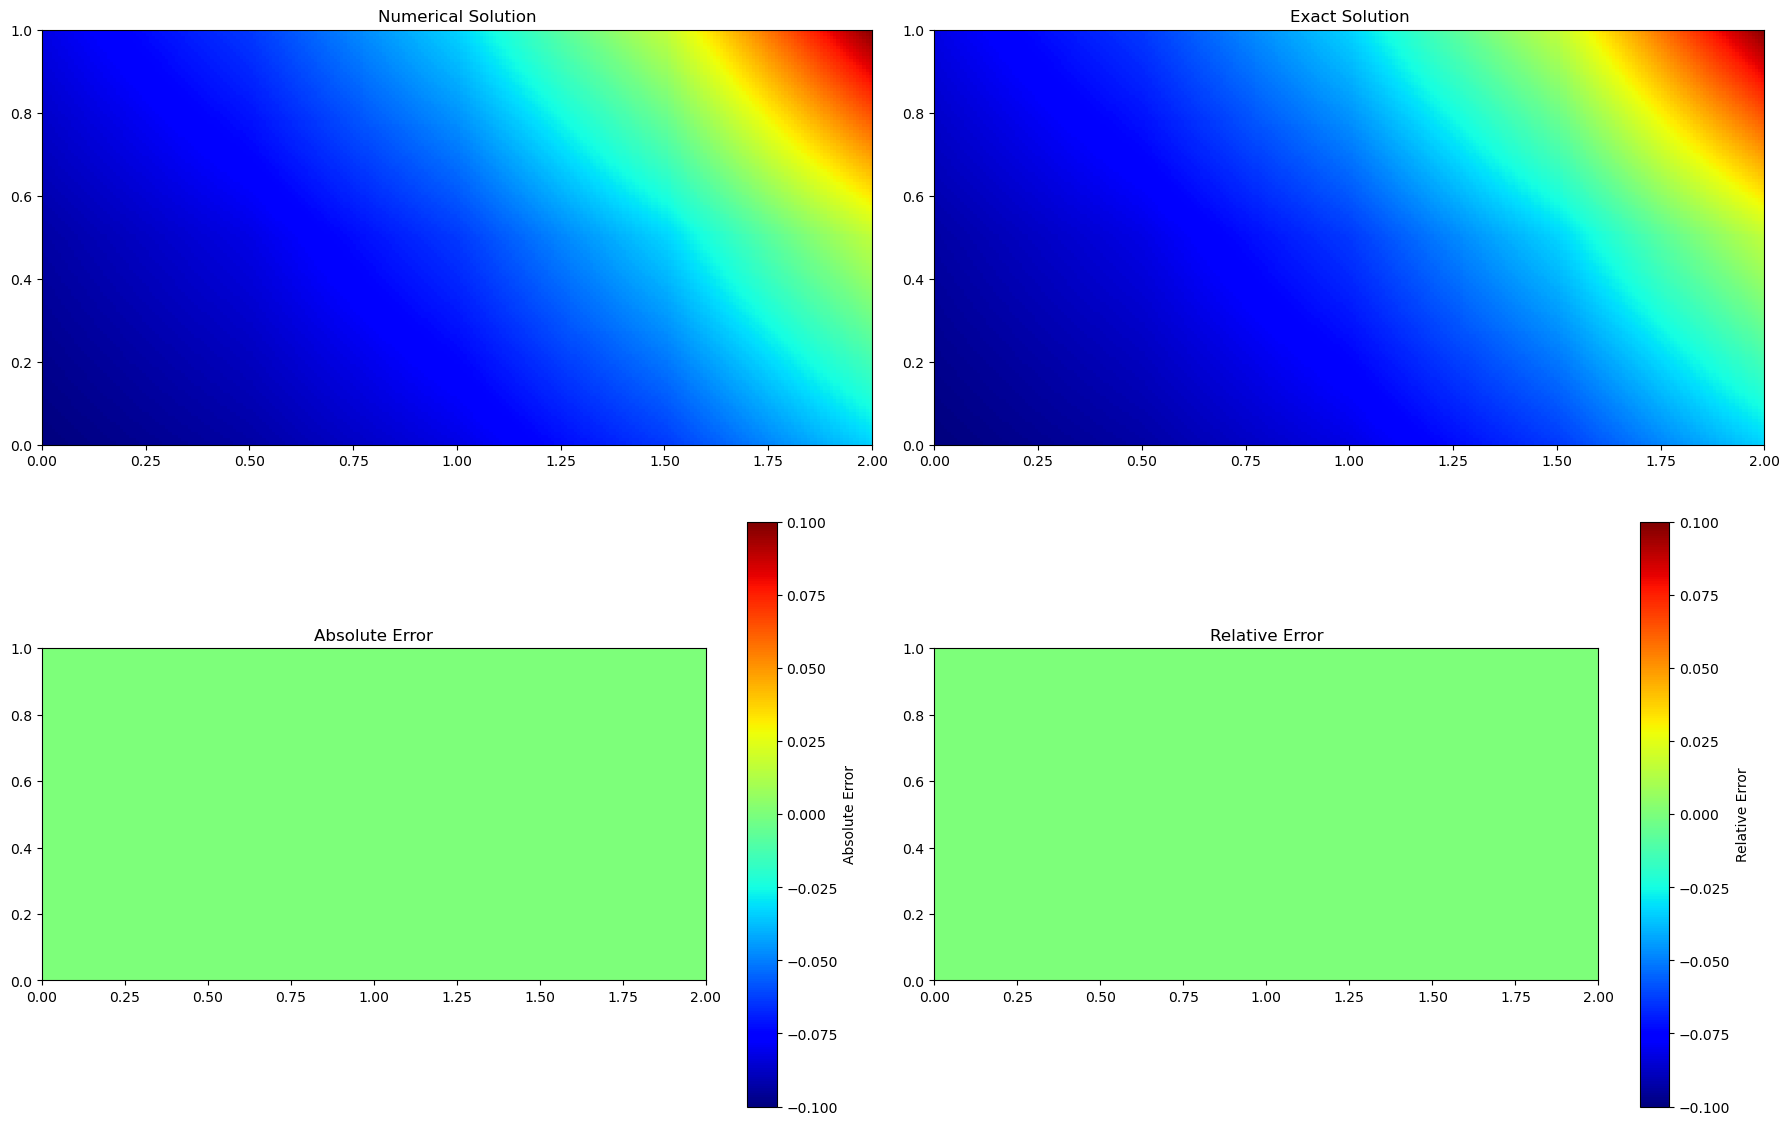

In [19]:
T=0
#在xcg[0]中找到T最相近的值的索引
idx = np.where((xcg[2] - T)==0)[0]

Ufem=analyticalParabolic(xcg)

solution=model(Graph[0].to('cuda'))
print(solution.shape)
#solution = Ufem
solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))
solution=solution.detach().cpu().numpy()
solution_values = solution[idx]
print('solution_values:',solution_values)

x_values = xcg[0][idx]
y_values = xcg[1][idx]

Ufem_values = Ufem[idx]
#把Udem_values和solution_values都reshape成和x_values一样的形状
Ufem_values = Ufem_values.reshape(x_values.shape[0],1)
#检查真解和数值解的形状是否一致，如果不一致就统一成solution的形状
porder=1 # Polywwwnomial order for solution and geometry basis
nel=[4,2] # Number of element in x and y axis

lims = np.array([[0,2],[0,1]]) # Domain limits
msh2=mesh_hcube(etype,lims,nel,porder).getmsh() # Create mesh object
ndof=msh2.xcg.shape[1] #总节点数，也就是总自由度数
print('ndof:',ndof)
print(Ufem_values.size)
print(msh2.e2vcg)
#这里要大改！！！👇
if Ufem.shape!=solution.shape:
    Ufem=Ufem.reshape(solution.shape)
fig, axes, cbar = visualize_fem(
    msh2, 
    udg=solution_values, 
    ufem=Ufem_values,        # 传入真解
    opts={"plot_elem": True, "nref": 6}, 
    which_bnd=[]
)

# 分别设置三个子图的标题
titles = ['Numerical Solution', 'Exact Solution', 'Difference']
for ax, title in zip(axes, titles):
    ax.tick_params(axis='both', which='both', 
                   bottom=False, left=False, 
                   top=False, labelbottom=False, labelleft=False)
    ax.set_title(title)
    ax.axis('off')

plt.margins(0,0)
plt.tight_layout()              # 自动调整子图间距
plt.show()

idx: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164]
solution_values: [[ 1.64872127]
 [ 2.71828183]
 [ 4.48168907]
 [ 7.3890561 ]
 [12.18249396]
 [ 2.71828183]
 [ 4.46988797]
 [ 7.43410671]
 [12.21890775]
 [20.08553692]
 [ 4.48168907]
 [ 7.3890561 ]
 [12.18249396]
 [20.08553692]
 [33.11545196]]
Ufem_values: [[ 1.64872127]
 [ 2.71828183]
 [ 4.48168907]
 [ 7.3890561 ]
 [12.18249396]
 [ 2.71828183]
 [ 4.48168907]
 [ 7.3890561 ]
 [12.18249396]
 [20.08553692]
 [ 4.48168907]
 [ 7.3890561 ]
 [12.18249396]
 [20.08553692]
 [33.11545196]]


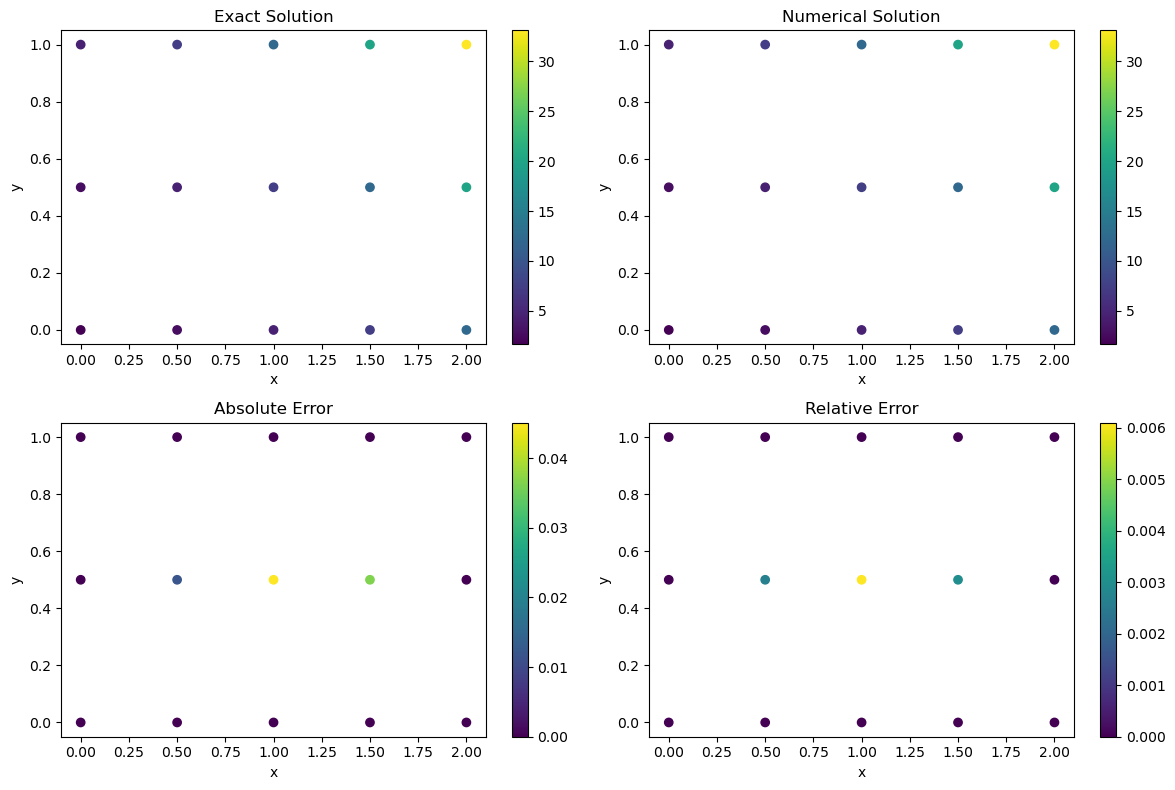

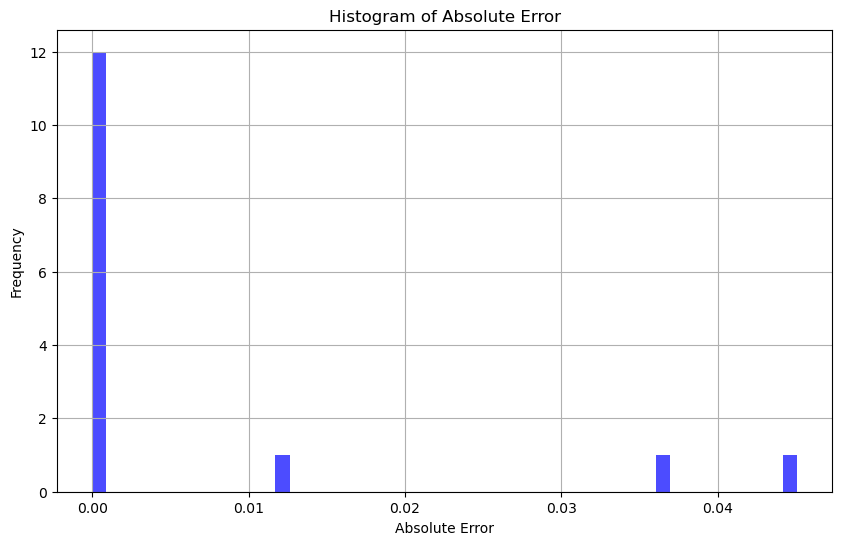

In [ ]:
#固定T
Ufem=analyticalParabolic(xcg)
#Ufem.reshape(ndof,1)
solution=model(Graph[0].to('cuda'))
#solution = Ufem
solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))
solution=solution.detach().cpu().numpy()


T=0.5
#在xcg[0]中找到T最相近的值的索引
idx = np.where((xcg[2] - T)==0)[0]
print('idx:',idx)
#提取对应的x坐标和解值
x_values = xcg[0][idx]
y_values = xcg[1][idx]
solution_values = solution[idx]
Ufem_values = Ufem[idx]
#把Udem_values和solution_values都reshape成和x_values一样的形状
Ufem_values = Ufem_values.reshape(x_values.shape[0],1)
#reshape一下

#画四张热力图 ，真值、数值解和绝对误差、相对误差
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# 画出真值
sc = axes[0, 0].scatter(x_values, y_values, c=Ufem_values, cmap='viridis')
axes[0, 0].set_title('Exact Solution')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(sc, ax=axes[0, 0])
# 画出数值解
sc = axes[0, 1].scatter(x_values, y_values, c=solution_values, cmap='viridis')
axes[0, 1].set_title('Numerical Solution')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(sc, ax=axes[0, 1])
# 画出绝对误差
absolute_error = np.abs(Ufem_values - solution_values)
sc = axes[1, 0].scatter(x_values, y_values, c=absolute_error, cmap='viridis')
axes[1, 0].set_title('Absolute Error')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(sc, ax=axes[1, 0])
# 画出相对误差
relative_error = np.abs((Ufem_values - solution_values) / Ufem_values)
sc = axes[1, 1].scatter(x_values, y_values, c=relative_error, cmap='viridis')
axes[1, 1].set_title('Relative Error')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(sc, ax=axes[1, 1])
plt.tight_layout()
plt.show()
# 画出误差的直方图
plt.figure(figsize=(10, 6))
plt.hist(absolute_error, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Absolute Error')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

